In [1]:
import numpy as np
import cv2
import random
import os
import matplotlib.pyplot as plt
import torch

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [2]:
def blur_bbox_regions(image, bboxes, rate=15):
    # Make a copy of the image to avoid modifying the original
    output_image = image.copy()

    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox.int().tolist()

        if (y_max - y_min) // rate > 0 and (x_max - x_min) // rate > 0: # only if roi is large enough
            # Extract the region of interest (ROI)
            roi = output_image[y_min:y_max, x_min:x_max]
            
            # Apply the blur to the ROI
            blurred_roi = cv2.resize(roi, ((x_max - x_min) // rate, (y_max - y_min) // rate))
            blurred_roi = cv2.resize(blurred_roi, (x_max - x_min, y_max - y_min), interpolation=cv2.INTER_AREA)
            
            # Place the blurred ROI back into the image
            output_image[y_min:y_max, x_min:x_max] = blurred_roi

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Blurred image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    return output_image


## Example usage, using val data

In [3]:
from detectron2.structures import BoxMode

# Only for train, val dataset
def get_face_dicts(img_dir, annot_dir, phase) -> list[dict]:
    annot_file = os.path.join(annot_dir, f"wider_face_{phase}_bbx_gt.txt")
    with open (annot_file, 'r') as f:
        lines = f.readlines()

    dataset_dicts = []

    i = 0
    idx = 0
    while i < len(lines):
        record = {}

        image_path = lines[i].strip()
        image_full_path = os.path.join(img_dir, image_path)
        height, width = cv2.imread(image_full_path).shape[:2]

        record["file_name"] = image_full_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []

        num_faces = int(lines[i + 1].strip())
        for j in range(num_faces):
            bbox = list(map(int, lines[i + 2 + j].strip().split())) # # even 1 bbox when num_faces = 0 
            x, y, w, h = bbox[:4] # (x, y) : top-left
            xmin = x
            xmax = x + w
            ymin = y
            ymax = y + h

            poly = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
            poly = [p for x in poly for p in x] # flatten list of list

            obj = {
                 "bbox": [x, y, w, h],
                 "bbox_mode": BoxMode.XYWH_ABS,
                 "segmentation": [poly],
                 "category_id": 0,
            }           
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
        i += max(2 + num_faces, 3) # 3 when num_faces = 0 
        idx += 1

    return dataset_dicts

In [4]:
# example
p = 'val'
img_dir = f'/home/minwoo/yai/Face_Mosaic/data/widerface/WIDER_{p}/images'
annot_dir = '/home/minwoo/yai/Face_Mosaic/data/widerface/wider_face_split'
dataset_dicts = get_face_dicts(img_dir, annot_dir, p)

# Remove existing dataset
dataset_name = f"face_{p}"
if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)
    MetadataCatalog.remove(dataset_name)

DatasetCatalog.register("face_" + p, lambda p=p: get_face_dicts(img_dir, annot_dir, p))
MetadataCatalog.get("face_" + p).set(thing_classes=["face"])

namespace(name='face_val', thing_classes=['face'])

In [5]:
face_metadata = MetadataCatalog.get("face_val")
class_names = face_metadata.get("thing_classes", [])
print(class_names)

['face']


[tensor([274., 102., 360., 224.])]


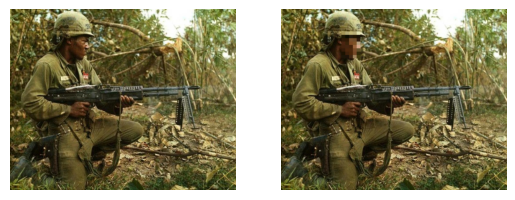

In [6]:
# Example usage
example = random.sample(dataset_dicts, 1)

image = cv2.imread(example[0]['file_name'])

pred_boxes = []
num_bboxes = len(example[0]['annotations'])
for i in range(num_bboxes):
    x_min = example[0]['annotations'][i]['bbox'][0]
    y_min = example[0]['annotations'][i]['bbox'][1]
    w = example[0]['annotations'][i]['bbox'][2]
    h = example[0]['annotations'][i]['bbox'][3]

    x_max = x_min + w
    y_max = y_min + h

    pred_boxes.append(torch.Tensor([x_min, y_min, x_max, y_max]))
print(pred_boxes)
torch.stack(pred_boxes, 0)

# Apply the blurring function
blurred_image = blur_bbox_regions(image=image, bboxes=pred_boxes)